In [128]:
import pickle
from universal.algos import *
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from universal import tools
from universal import result
from itertools import chain
from PPO import PPO
from torch.distributions import Categorical
from env.Portfolio_management import CustomEnv
import seaborn as sns
EPISODES = 1000
lr = 0.001
gamma = 0.98
lmbda = 0.95
epochs = 3
eps_clip = 0.2
MAX_STEPS = 2835

In [159]:
df = pd.read_csv('SP500_30.csv')
df_original_train = df.head(round(0.8*len(df)))
df_original_test = df.tail(round(0.2*len(df)))

df_ob = pd.read_csv('SP500_30X5.csv')
df_ob_train = df_ob.head(round(0.8 * len(df_ob)))
df_ob_test = df_ob.tail(round(0.2 * len(df_ob)))
train_set = (df_ob_train - np.mean(df_ob_train.to_numpy())) / np.std(df_ob_train.to_numpy())
test_set = (df_ob_test - np.mean(df_ob_train.to_numpy())) / np.std(df_ob_train.to_numpy())

In [167]:

train_set = pd.DataFrame(train_set)
test_set = pd.DataFrame(test_set)

#model = PPO(1500, 15)
pkl_file = open('model/2400.pkl', 'rb')
model = pickle.load(pkl_file)
model.train()
n_epi =0
total_reward = []
total_test_reward = []
total_portfolio_wealth = []
stock_weight = []
stock_weight = pd.DataFrame(stock_weight)

In [170]:
train_set

,AAL-open,AAL-high,AAL-low,AAL-close,AAL-volume,AAPL-open,AAPL-high,AAPL-low,AAPL-close,AAPL-volume,...,ALXN-open,ALXN-high,ALXN-low,ALXN-close,ALXN-volume,AMAT-open,AMAT-high,AMAT-low,AMAT-close,AMAT-volume
0,-0.816532,-0.815645,-0.824336,-0.822208,-0.934703,0.117207,0.129396,0.102638,0.119691,1.721576,...,0.567648,0.583256,0.563923,0.577403,-1.065027,-0.845975,-0.841186,-0.846862,-0.842428,-0.783178
1,-0.819725,-0.817596,-0.830899,-0.827351,-0.926287,0.123543,0.144928,0.115308,0.132234,1.204743,...,0.577403,0.582901,0.547605,0.553281,-1.053546,-0.843315,-0.839945,-0.844734,-0.841541,-0.848981
2,-0.827529,-0.826465,-0.833737,-0.830721,-0.939696,0.131170,0.138442,0.101356,0.101752,1.609141,...,0.553990,0.555587,0.509116,0.516211,-1.028560,-0.841364,-0.841009,-0.844911,-0.841541,-0.876082
3,-0.830189,-0.818838,-0.831076,-0.823804,-0.901855,0.100003,0.116296,0.089893,0.099496,1.021922,...,0.514615,0.551685,0.509826,0.548137,-1.039552,-0.839590,-0.839235,-0.842339,-0.839590,-0.877447
4,-0.818838,-0.818483,-0.850409,-0.835688,-0.518378,0.093187,0.111228,0.091920,0.098431,0.491364,...,0.592657,0.605604,0.415289,0.470450,-0.978532,-0.837994,-0.835688,-0.841718,-0.837461,-0.726873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,-0.290104,-0.285670,-0.305003,-0.302520,-0.942720,1.169280,1.230649,1.168925,1.199787,0.902430,...,1.195353,1.272331,1.195353,1.263107,-1.042542,-0.470310,-0.462151,-0.471906,-0.462506,-0.813430
1003,-0.310324,-0.294183,-0.311033,-0.303229,-0.948890,1.186041,1.211139,1.182582,1.195885,-0.485911,...,1.237212,1.257430,1.185686,1.193224,-1.033782,-0.463570,-0.462506,-0.469423,-0.464102,-0.950481
1004,-0.297908,-0.293651,-0.307615,-0.299859,-0.971056,1.191983,1.207591,1.189322,1.205640,-0.649145,...,1.206172,1.206172,1.164136,1.168393,-1.030125,-0.463392,-0.456120,-0.463392,-0.457539,-0.931993
1005,-0.289217,-0.275028,-0.290281,-0.280349,-0.968606,1.206527,1.230827,1.202448,1.227102,-0.607665,...,1.145513,1.191806,1.138773,1.189855,-1.053946,-0.457362,-0.456120,-0.462860,-0.459845,-0.979585


In [171]:
test_set

,AAL-open,AAL-high,AAL-low,AAL-close,AAL-volume,AAPL-open,AAPL-high,AAPL-low,AAPL-close,AAPL-volume,...,ALXN-open,ALXN-high,ALXN-low,ALXN-close,ALXN-volume,AMAT-open,AMAT-high,AMAT-low,AMAT-close,AMAT-volume
1007,-0.281058,-0.281058,-0.294361,-0.284605,-1.007018,1.245903,1.261334,1.243597,1.258141,-0.675807,...,1.170876,1.196772,1.145513,1.157574,-1.052640,-0.448848,-0.448848,-0.459847,-0.452396,-0.928879
1008,-0.284428,-0.257309,-0.286734,-0.262612,-0.958073,1.251224,1.265325,1.241823,1.264881,-0.580990,...,1.154204,1.180631,1.147286,1.170167,-1.045416,-0.449735,-0.447961,-0.456298,-0.455766,-0.968262
1009,-0.256936,-0.255517,-0.264918,-0.259951,-1.012159,1.265591,1.274104,1.258319,1.259560,-0.727929,...,1.177439,1.186139,1.148350,1.160057,-1.054238,-0.451686,-0.451686,-0.461441,-0.457362,-0.877433
1010,-0.258000,-0.236361,-0.259064,-0.242924,-0.974592,1.276587,1.289713,1.270734,1.280312,-0.675251,...,1.172650,1.189145,1.151715,1.182405,-1.030241,-0.450267,-0.448325,-0.456475,-0.454879,-0.872753
1011,-0.245585,-0.245230,-0.259951,-0.257823,-0.972587,1.283505,1.312238,1.279603,1.310997,-0.494499,...,1.190387,1.230293,1.182050,1.213090,-1.024907,-0.454169,-0.453282,-0.460909,-0.458958,-0.907227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,-0.126039,-0.114687,-0.133311,-0.128167,-1.019564,1.881146,1.906953,1.873963,1.892054,-0.246103,...,1.017098,1.036343,0.989430,1.010713,-1.035813,-0.140937,-0.122846,-0.145017,-0.138809,-0.911672
1255,-0.135084,-0.126216,-0.160980,-0.159738,-0.993202,1.860483,1.874672,1.755836,1.762930,0.452072,...,0.998829,1.008762,0.966903,0.976303,-1.059185,-0.151225,-0.147500,-0.187763,-0.184925,-0.785615
1256,-0.161689,-0.154595,-0.201420,-0.201243,-0.961827,1.738099,1.822881,1.683115,1.691806,0.206323,...,0.995991,1.020025,0.915112,0.915466,-1.047453,-0.197340,-0.171001,-0.226961,-0.226961,-0.764569
1257,-0.209047,-0.170380,-0.218447,-0.176056,-0.963526,1.662363,1.820043,1.647641,1.807805,0.126602,...,0.878751,0.958567,0.860305,0.954310,-1.046679,-0.242924,-0.192374,-0.260838,-0.192551,-0.703270


In [168]:
env = CustomEnv(df_original_train,train_set)
s = env.reset()  # observation

done = False
t = 0
test_reward_list = 0
n_epi +=1
h_out = (torch.zeros([1, 1, 32], dtype=torch.float), torch.zeros([1, 1, 32], dtype=torch.float))
s = env.reset() # observation
a = 0
done = False
t = 0
my_total_wealth = 1
reward_list = 0
while (done == False):
    t = t + 1
    h_in = h_out
    s = s.to_numpy()
    prob, h_out = model.pi(torch.from_numpy(s.reshape(-1)).float(), h_in)
    prob = prob.view(-1)
    np_array= prob.detach().numpy()
    print(prob)
    count = np_array.shape[0]
    for i in range(count):
         if np_array[i] == np_array.max():
            action = i
            break;
    
    print(action)
    next_s, r, done, _, result = env.step(action)    
    a = a+1
    my_total_wealth = my_total_wealth * result.total_wealth
    #print(result.total_wealth)
    total_portfolio_wealth.append(my_total_wealth)
    test_reward_list = test_reward_list + r
    stock_weight = stock_weight.append(result.B)
   
    s = next_s
    if done:
        break


tensor([0.1312, 0.0049, 0.0034, 0.0092, 0.0058, 0.0027, 0.0020, 0.0012, 0.6957,
        0.0399, 0.0076, 0.0780, 0.0076, 0.0077, 0.0031],
       grad_fn=<ViewBackward0>)
8
tensor([0.2533, 0.0060, 0.0023, 0.0061, 0.0083, 0.0018, 0.0014, 0.0012, 0.2590,
        0.0282, 0.0100, 0.4064, 0.0062, 0.0081, 0.0018],
       grad_fn=<ViewBackward0>)
11
tensor([2.0132e-01, 2.9519e-03, 9.2891e-04, 2.4112e-03, 4.5509e-03, 7.5487e-04,
        5.5214e-04, 6.2810e-04, 1.4184e-01, 1.6002e-02, 6.4966e-03, 6.1446e-01,
        3.0736e-03, 3.4322e-03, 6.0653e-04], grad_fn=<ViewBackward0>)
11
tensor([1.9052e-01, 2.4757e-03, 7.3730e-04, 1.9576e-03, 3.9466e-03, 5.7848e-04,
        4.3200e-04, 5.0518e-04, 1.2435e-01, 1.3586e-02, 5.9300e-03, 6.4918e-01,
        2.5342e-03, 2.7969e-03, 4.6590e-04], grad_fn=<ViewBackward0>)
11
tensor([1.9658e-01, 2.3656e-03, 7.0584e-04, 1.8689e-03, 3.7967e-03, 5.9732e-04,
        4.3129e-04, 5.1109e-04, 1.3644e-01, 1.4371e-02, 5.7057e-03, 6.3075e-01,
        2.5927e-03, 2.8406e-03,

tensor([0.3221, 0.0146, 0.0020, 0.0033, 0.0126, 0.0014, 0.0013, 0.0021, 0.0659,
        0.0237, 0.0202, 0.5045, 0.0072, 0.0180, 0.0012],
       grad_fn=<ViewBackward0>)
11
tensor([0.3292, 0.0136, 0.0019, 0.0032, 0.0120, 0.0014, 0.0012, 0.0020, 0.0648,
        0.0231, 0.0200, 0.5026, 0.0068, 0.0170, 0.0011],
       grad_fn=<ViewBackward0>)
11
tensor([0.3236, 0.0139, 0.0020, 0.0033, 0.0122, 0.0014, 0.0012, 0.0020, 0.0655,
        0.0233, 0.0199, 0.5065, 0.0070, 0.0173, 0.0011],
       grad_fn=<ViewBackward0>)
11
tensor([0.4372, 0.0237, 0.0028, 0.0044, 0.0197, 0.0019, 0.0018, 0.0033, 0.0603,
        0.0287, 0.0296, 0.3404, 0.0099, 0.0348, 0.0016],
       grad_fn=<ViewBackward0>)
0
tensor([0.4715, 0.0645, 0.0041, 0.0074, 0.0428, 0.0030, 0.0035, 0.0073, 0.0411,
        0.0332, 0.0479, 0.0916, 0.0160, 0.1636, 0.0025],
       grad_fn=<ViewBackward0>)
0
tensor([0.3981, 0.0743, 0.0038, 0.0066, 0.0456, 0.0026, 0.0030, 0.0069, 0.0297,
        0.0262, 0.0473, 0.0320, 0.0145, 0.3074, 0.0021],
     

tensor([0.0602, 0.0761, 0.0013, 0.0032, 0.0422, 0.0010, 0.0016, 0.0033, 0.0061,
        0.0084, 0.0217, 0.0024, 0.0094, 0.7623, 0.0008],
       grad_fn=<ViewBackward0>)
13
tensor([0.0588, 0.0762, 0.0013, 0.0032, 0.0421, 0.0010, 0.0015, 0.0032, 0.0061,
        0.0083, 0.0215, 0.0024, 0.0094, 0.7643, 0.0008],
       grad_fn=<ViewBackward0>)
13
tensor([5.7200e-02, 7.6194e-02, 1.3150e-03, 3.1725e-03, 4.1999e-02, 9.4243e-04,
        1.5468e-03, 3.2088e-03, 5.9528e-03, 8.1607e-03, 2.1252e-02, 2.3286e-03,
        9.3278e-03, 7.6663e-01, 7.6590e-04], grad_fn=<ViewBackward0>)
13
tensor([0.0578, 0.0762, 0.0013, 0.0032, 0.0420, 0.0009, 0.0015, 0.0032, 0.0060,
        0.0082, 0.0213, 0.0023, 0.0093, 0.7659, 0.0008],
       grad_fn=<ViewBackward0>)
13
tensor([0.0617, 0.0761, 0.0014, 0.0033, 0.0423, 0.0010, 0.0016, 0.0033, 0.0062,
        0.0085, 0.0220, 0.0025, 0.0094, 0.7601, 0.0008],
       grad_fn=<ViewBackward0>)
13
tensor([0.0581, 0.0762, 0.0013, 0.0032, 0.0421, 0.0009, 0.0015, 0.0032, 0.0060,

In [169]:
print(my_total_wealth)

7.467682390878352


In [133]:
stock_weight

,AAL-close,AAPL-close,AAP-close,ABBV-close,ABC-close,ABT-close,ACN-close,ADBE-close,ADI-close,ADM-close,...,AIV-close,AIZ-close,AJG-close,AKAM-close,ALB-close,ALGN-close,ALK-close,ALL-close,ALXN-close,AMAT-close
1017,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
1018,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
1019,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
1020,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
1021,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
1243,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
1244,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
1245,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333


In [156]:
sp_data = pd.read_csv('SP500_30.csv')
test_set = sp_data.tail(round(0.2*len(sp_data)))
test_set

,AAL-close,AAPL-close,AAP-close,ABBV-close,ABC-close,ABT-close,ACN-close,ADBE-close,ADI-close,ADM-close,...,AIV-close,AIZ-close,AJG-close,AKAM-close,ALB-close,ALGN-close,ALK-close,ALL-close,ALXN-close,AMAT-close
1007,45.06,132.04,162.73,60.52,91.07,42.40,115.43,116.13,77.48,43.46,...,45.30,90.45,54.06,63.55,94.35,94.17,97.20,77.99,126.37,35.60
1008,46.30,132.42,164.83,60.84,91.65,42.54,116.98,116.44,76.51,43.54,...,45.12,91.36,54.71,63.85,93.91,95.98,98.41,78.35,127.08,35.41
1009,46.45,132.12,164.05,60.42,91.17,42.74,117.60,116.85,76.53,43.83,...,45.72,92.93,55.17,63.95,93.70,96.97,97.35,78.88,126.51,35.32
1010,47.41,133.29,162.39,60.51,90.48,43.22,118.59,117.65,77.92,43.71,...,45.52,94.32,55.55,63.60,94.75,97.61,98.02,79.61,127.77,35.46
1011,46.57,135.02,164.37,60.82,90.82,43.65,120.00,117.58,77.84,43.73,...,45.36,95.25,55.56,63.55,91.19,98.39,96.30,79.80,129.50,35.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,53.88,167.78,117.29,116.34,99.29,62.18,160.46,199.38,91.65,42.46,...,40.80,93.06,69.19,67.56,109.20,255.57,64.08,98.72,118.09,53.28
1255,52.10,160.50,113.93,115.17,96.02,61.69,156.90,195.64,89.11,41.43,...,40.55,91.95,68.57,65.72,105.51,257.38,64.56,97.94,116.15,50.68
1256,49.76,156.49,109.86,109.51,91.90,58.73,151.83,190.27,85.40,40.60,...,39.67,88.18,66.27,62.81,105.15,242.40,62.74,95.02,112.72,48.31
1257,51.18,163.03,112.20,111.20,91.54,58.86,154.69,194.47,88.54,42.00,...,39.62,88.49,65.40,63.67,107.54,241.45,63.19,96.60,114.91,50.25


In [135]:
wealth = 1
BestMarkowitz_list = []
for i in range(24):
    if i>0:
        new_test = test_set.iloc[10*i:10*i+10]
        algo = BestMarkowitz()
        result = algo.run(new_test.reset_index(drop=True))
        map_X = result.X
        pre_tset = test_set.iloc[10*i-10:10*i]
        result = algo.run(pre_tset.reset_index(drop=True))
        weights =result.B
        r = (map_X - 1) * weights
        r = r.sum(axis=1) + 1
        total_wealth = r.prod()
        wealth = wealth * total_wealth
        BestMarkowitz_list.append(wealth)
        print(total_wealth)
print("-------------------------")
print(wealth)

1.006475113182044
1.0265365763541405
1.0199911060869478
1.0286548780477671
0.9725359949635679
0.9975367402825313
0.9959379669535141
0.9809006936515604
1.0474345040309507
1.038817310345453
0.9504504517175209
0.9392875543229702
1.0295767462365357
1.022497897965447
0.9647338106472702
1.0038944299967096
0.9833427987799351
1.0526683339024108
1.0145999835582575
1.08153901677777
1.0100399556953934
0.9998481192852557
1.0596103772440422
-------------------------
1.2367974713830514


In [136]:
wealth = 1
BCRP_list = []
for i in range(24):
    if i>0:
        new_test = test_set.iloc[10*i:10*i+10]
        algo = BCRP()
        result = algo.run(new_test.reset_index(drop=True))
        map_X = result.X
        pre_tset = test_set.iloc[10*i-10:10*i]
        result = algo.run(pre_tset.reset_index(drop=True))
        weights =result.B
        r = (map_X - 1) * weights
        r = r.sum(axis=1) + 1
        total_wealth = r.prod()
        wealth = wealth * total_wealth
        BCRP_list.append(wealth)
        print(total_wealth)
print("-------------------------")
print(wealth)

1.0064751112909756
1.0265365853658535
1.0199911150599732
1.0286548784338487
0.9725359911406423
0.997536767369412
0.9959379615952735
0.9809006835544832
1.0474345730027552
1.0388173108688474
0.9504504504504507
0.9392875492378833
1.0295767465578787
1.0224978973927672
0.9647338080705323
1.0282188251245834
0.9833427976528492
1.0526683349822497
1.0145999841734592
1.0879268020531134
1.0100399549226515
0.9998481166464158
1.0596103779513422
-------------------------
1.2742469819204811


In [137]:
wealth = 1
PAMR_list = []
for i in range(24):
     if i>0:
        new_test = test_set.iloc[10*i:10*i+10]
        algo = PAMR()
        result = algo.run(new_test)
        wealth = wealth * result.total_wealth
        PAMR_list.append(wealth)
        print(result.total_wealth)
print("-------------------------")
print(wealth)

1.057292411780559
1.0129846294622042
1.0006813610335943
1.0006016300210687
1.0218788883742822
0.9472771968648819
0.9100534423570882
1.0173863394073062
0.9598303278591125
0.9985823895111428
1.0035800192320248
0.9519597134464681
1.0219655162256158
1.0726349324463142
1.0052200870396102
1.0086125434717517
0.9992454778784546
0.9847759410789723
0.9754668240491302
0.9961342857221565
1.005930026562456
1.0035726992810672
0.9577723663063832
-------------------------
0.9043277767613883


In [138]:
wealth = 1
RMR_list = []
for i in range(24):
     if i>0:
        new_test = test_set.iloc[10*i:10*i+10]
        algo = RMR()
        result = algo.run(new_test)
        wealth = wealth * result.total_wealth
        PAMR_list.append(wealth)
        print(result.total_wealth)
print("-------------------------")
print(wealth)

1.0165271779427598
1.0148028695800992
0.9875357648888698
0.9964329250583862
1.0342511970111183
0.9715899336906018
1.0071436312953113
0.9858361845064373
1.0027787115535545
0.9919672729874793
1.0546473313367013
0.9657095363472922
1.007525065630329
1.0312156962347465
0.9946362203162679
1.0021745859243747
1.0183068460294757
1.0374103145068492
1.0001056752533073
1.025960252897862
1.0279178308033883
1.002702371096925
0.9555700070273064
-------------------------
1.134422025254712


In [139]:
wealth = 1
OLMAR_list = []
for i in range(24):
     if i>0:
        new_test = test_set.iloc[10*i:10*i+10]
        algo = OLMAR()
        result = algo.run(new_test)
        wealth = wealth * result.total_wealth
        PAMR_list.append(wealth)
        print(result.total_wealth)
print("-------------------------")
print(wealth)

1.0165271779427598
1.0148028695800992
0.9824086787318789
1.0141721332014244
1.0342511970111183
0.9715899336906018
1.0071436312953113
0.9858361845064373
1.0027787115535545
1.0017384455708978
1.0546473313367013
0.9657095363472922
1.007525065630329
1.058158619424026
0.9946362203162679
1.0021745859243747
1.0183068460294757
1.0374103145068492
1.0066089856369835
1.025960252897862
1.0005509254692575
1.0082349983080245
0.9555700070273064
-------------------------
1.172522820415601


In [140]:
wealth = 1
WMAMR_list = []
for i in range(24):
    if i>0:
        new_test = test_set.iloc[10*i:10*i+10]
        algo = WMAMR()
        result = algo.run(new_test)
        wealth = wealth * result.total_wealth
        WMAMR_list.append(wealth)
        print(result.total_wealth)
print("-------------------------")
print(wealth)

1.0370216978597813
0.987276376209337
0.9897839223992494
0.9651851190329513
1.0346032977662676
0.9492836085782853
0.9544053152697484
0.9796418755736168
0.9808636940689196
0.9863222685295147
1.0411545133273266
0.9758734585865779
0.9635567421876238
1.0760793081740154
1.0143319461871887
0.9836041226429322
0.9360983131993642
1.0134885855857296
1.0176827527695074
0.9933571295089528
1.0030834746819466
1.0062994129671703
0.9008845957020905
-------------------------
0.7965214021431727


In [141]:
wealth = 1
BAH_list = []
for i in range(24):
    if i>0:
        new_test = test_set.iloc[10*i:10*i+10]
        algo = BAH()
        result = algo.run(new_test)
        wealth = wealth * result.total_wealth
        BAH_list.append(wealth)
        print(result.total_wealth)
print("-------------------------")
print(wealth)

1.0011731923484692
0.9989902995454473
0.991666306796374
1.007182782586411
1.0201557134871861
0.9854127024056738
1.0294986900234926
1.0070233986423514
0.9823111098915668
1.0204448617313253
1.0118005189164625
0.9824450992044215
0.9924734893805077
1.032459715791353
0.9891095906601773
1.0281798128264221
1.0118496823931986
1.0025065437279514
1.0091182037747664
0.9942146539485834
1.0182834879908318
1.023381179579537
1.0183169614148964
-------------------------
1.167497990113997


In [142]:
wealth = 1
Anticor_list = []
for i in range(24):
    if i>0:
        new_test = test_set.iloc[10*i:10*i+10]
        algo = Anticor()
        result = algo.run(new_test)
        wealth = wealth * result.total_wealth
        Anticor_list.append(wealth)
        print(result.total_wealth)
print("-------------------------")
print(wealth)

1.0013588728191447
0.9988541521249413
0.9916958778693623
1.0072539391141015
1.0200716536596266
0.9851736286328174
1.0293185630628383
1.0069557672293126
0.9824246910245583
1.0200705707010405
1.0117691850973185
0.9825511607933199
0.9922593388113848
1.0325238022244796
0.9894301262209091
1.028035702701177
1.0117883439928743
1.0018170847596288
1.0094936495687727
0.9944258466911741
1.0180455910618573
1.0232648820757424
1.017745984926995
-------------------------
1.165591754032622


In [157]:
wealth = 1
CORN_list = []
for i in range(24):
    if i>0:
        new_test = test_set.iloc[10*i:10*i+10]
        algo = CORN()
        result = algo.run(new_test)
        wealth = wealth * result.total_wealth
        CORN_list.append(wealth)
        print(result.total_wealth)
print("-------------------------")
print(wealth)

0.9961532536636363
1.0037775708873902
0.9973436151205362
1.0036270318986227
1.07696591723923
0.9684435500923202
0.9876084563426775
1.00891032732726
0.9913609265352387
1.0061743576731046
1.0299002797607504
0.9739358516983502
0.9962940047809944
1.0750609292023645
0.9829885983263901
1.0199024771566823
1.0172365066125533
1.0018170847596288
1.0062119148835622
0.9944258466911741
1.0180455910618573
1.0232648820757424
1.017745984926995
-------------------------
1.2081466810869885


<AxesSubplot:>

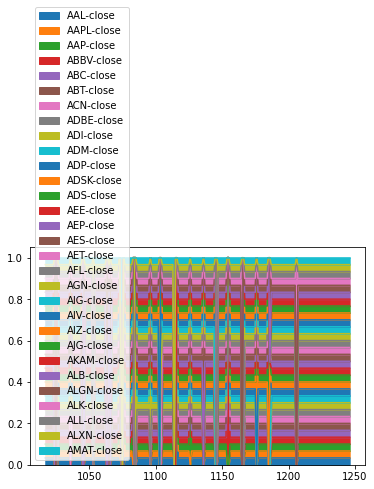

In [143]:
stock_weight.plot(kind="area",legend=True,stacked=True)

In [144]:
purr = [1.012254901962748,
1.0134803921616682,
1.002859477115538,
1.019607843400245,
1.0212418303288282,
1.0204248368785267,
1.0114379087389498,
1.0000000002070648,
1.0016339871670692,
1.0085784315959765,
1.0065359478501377,
1.010620915184806,
0.9979575164591817,
1.0069444440795061,
0.9922385596760934,
0.9979575135000343,
0.9963235260440108,
0.9861111127854753,
0.9914215808867071,
0.9906045755935048,
0.9934640306652667,
1.0040846906006649,
1.0089862012869737,
1.0093946931366875,
0.9987737982051867,
1.0159306456012496,
1.0179731250386466,
1.0061268597316049,
0.9975483765080886,
1.0049016284800372,
1.006944096163485,
1.001633798753846,
1.0036762035576454,
1.0008893441090125,
0.996379700447786,
1.002131245148711,
0.9957693734894443,
0.9781191039445798,
0.9773836760468769,
0.956056267013499,
0.9711325389164042,
1.0053299361595793,
1.0023882245687685,
1.0086393616992413,
0.9832670992284984,
0.9828993852796472,
0.9696616831209988,
0.938038283519783,
0.995401659540593,
1.0450430426355248,
1.020773922011336,
1.0082716477503904,
1.0156259267274172,
1.0001819408756607,
0.9847379550239043,
1.0200384941136333,
1.032173054425728,
1.0097425035457959,
1.007903933801539,
1.050191037919444,
1.0402627613004576,
1.0645318819246463,
1.0457784705332278,
1.0329084823234307,
1.0343793381188362,
1.0262896312441065,
0.9891505224101206,
0.9939308037451882,
0.9707648249675533,
0.9663522575813374,
0.9597334065020131,
0.9641459738882291,
0.9843702410750531,
1.0020205106199176,
1.0060653640572823,
1.047249326328633,
1.0064330780061337,
0.9836348131773501,
1.0141550709320117,
1.0384241915562007,
0.9994465129779582,
0.9817962434330936,
1.0053299361595798,
1.0093747895969445,
1.0079039338015392,
0.9880473805635666,
0.999078799029107,
1.0086393616992417,
1.0281282009883632,
1.0744601585436326,
1.0560744611010653,
1.0141550709320117,
1.0255542033464036,
1.0928458559861998,
1.082549865418362,
1.0634287400780922,
1.0851238630603215,
1.0843884351626187,
1.076298728287889,
1.0821821514695653,
1.1329266764110535,
1.1446935227742974,
1.1450612367231476,
1.1112315534288222,
1.1093929836845655,
1.0619578842827395,
1.059383886640741,
1.0660027377200654,
1.079240439878714,
1.1844066292502005,
1.056074461101079,
1.129249536922498,
1.1844066292502005,
1.1741106386823625,
1.157931224932903,
1.1722720689381059,
1.1310881066667546,
1.1218952579454708,
1.1112315534287815,
1.1141732650195926,
1.1108638394799304,
1.0722538748505386,
1.067473593515471,
1.0729893027482413,
1.0751955864413494,
1.060119314538444,
1.067473593515471,
1.0656350237712142,
1.067473593515471,
1.060119314538444,
1.0641641679758091,
1.0660027377200658,
1.1024064186563496,
1.069312163259728,
1.1472675204162144,
1.1649177899610792,
1.1781554921197277,
1.1880837687387145,
1.1836712013524981,
1.1803617758128362,
1.1899223384829714,
1.209411177772093,
1.2906759604682416,
1.306855374217701,
1.2939853860079036,
1.3222993600694577,
1.2954562418033089,
1.320460790325188,
1.2825862535935009,
1.29030824650663,
1.2811153978997647,
1.2928822442639505,
1.3017073782790216,
1.3013396643194264,
1.2906759598149022,
1.2881019621742458,
1.257581704435033,
1.266406839202998,
1.2678776949976587,
1.2836893947902628,
1.317886792016128,
1.3531873310879883,
1.3564967566259754,
1.3605416100612926,
1.354290472933984,
1.3359047755007234,
1.3601738961126277,
1.3351693476033932,
1.382972160929871,
1.3859138725191928,
1.377088737751228,
1.3645864634966105,
1.3741470261619062,
1.3965775770304845,
1.3987838607224758,
1.4175372721044017,
1.419375841847728,
1.441806392716306,
1.3564967566259762,
1.3892232980571804,
1.3656896053426066,
1.3708376006239196,
1.3741470261619064,
1.306119945658842,
1.2987656666855374,
1.3300213523220807,
1.3046490898641807,
1.3156805083241372,
1.3403173428847066,
1.3351693476033935,
1.3215639315027803,
1.3208285036054501,
1.3403173428847064,
1.3550259008313148,
1.3778241656485581,
1.382236733032541,
1.3568644705746409,
1.373779312213241,
1.3439944823713583,
1.4054027117984491,
1.4436449624596315,
1.4487929577409444,
1.4929186315807703,
1.5171877521926742,
1.5083626174247091,
1.5109366150653656,
1.505053191886722,
1.514981468500683,
1.5032146221433962,
1.5168200382440091,
1.533734879882609,
1.5756542700304434,
1.5837439769010782,
1.5668291352624784,
1.564255137621822,
1.5863179745417346,
1.5866856884903997,
1.6032328161803342,
1.6058068138209907,
1.5708739886977952,
1.5616811399811648,
1.5598425702378387,
]

In [145]:
purr

[1.012254901962748,
 1.0134803921616682,
 1.002859477115538,
 1.019607843400245,
 1.0212418303288282,
 1.0204248368785267,
 1.0114379087389498,
 1.0000000002070648,
 1.0016339871670692,
 1.0085784315959765,
 1.0065359478501377,
 1.010620915184806,
 0.9979575164591817,
 1.0069444440795061,
 0.9922385596760934,
 0.9979575135000343,
 0.9963235260440108,
 0.9861111127854753,
 0.9914215808867071,
 0.9906045755935048,
 0.9934640306652667,
 1.0040846906006649,
 1.0089862012869737,
 1.0093946931366875,
 0.9987737982051867,
 1.0159306456012496,
 1.0179731250386466,
 1.0061268597316049,
 0.9975483765080886,
 1.0049016284800372,
 1.006944096163485,
 1.001633798753846,
 1.0036762035576454,
 1.0008893441090125,
 0.996379700447786,
 1.002131245148711,
 0.9957693734894443,
 0.9781191039445798,
 0.9773836760468769,
 0.956056267013499,
 0.9711325389164042,
 1.0053299361595793,
 1.0023882245687685,
 1.0086393616992413,
 0.9832670992284984,
 0.9828993852796472,
 0.9696616831209988,
 0.938038283519783,
 0

In [146]:
LEN = 10

def avg(data):
    datasum = cnt = 0 
    for num in data:
        datasum += num
        cnt += 1
        if cnt == LEN: 
            yield datasum / LEN
            datasum = cnt = 0 
    if cnt: 
        yield datasum / cnt

print(list(avg(purr)))

[1.0111519609556616, 0.9976715692059457, 1.0057184049254406, 0.9918982808674887, 0.9901801214669039, 1.014964041619485, 1.0164348974148907, 1.0006231976142825, 1.0102205316793025, 1.0662601374842529, 1.1094297550794345, 1.135243274288775, 1.0719597036914574, 1.1344343036013023, 1.2801961129246995, 1.2831378240177265, 1.3542537015391176, 1.3935623226514298, 1.334139748547131, 1.3577837554463037, 1.4961912857238904, 1.5777134681429685, 1.5607618551095017]


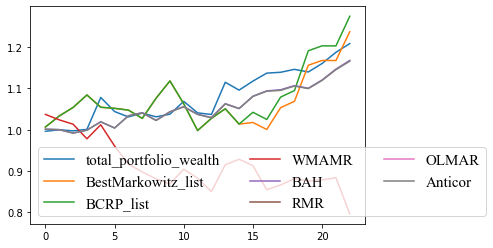

In [148]:
plt.plot(total_portfolio_wealth)
#plt.plot(list(avg(purr)))
plt.plot(BestMarkowitz_list)
plt.plot(BCRP_list)
plt.plot(WMAMR_list)
plt.plot(BAH_list)
plt.plot(RMR_list)
plt.plot(OLMAR_list)
plt.plot(Anticor_list)
plt.legend(["total_portfolio_wealth","BestMarkowitz_list","BCRP_list","WMAMR","BAH","RMR","OLMAR","Anticor"], ncol=3, prop={"family": "Times New Roman", "size": 15})
plt.show()